In [1]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
sys.path.append('../src')
from tsvae.utils.logger_utils import get_console_logger
logger = get_console_logger(__name__)
from os import path as pt

In [2]:
from experiments.experiment_utils import get_output_dir, update_config
from tsvae.dataset.data_pipeline import DataPipeline
from tsvae.models.network_pipeline import NetworkPipeline
from tsvae.utils.random_utils import set_seed


base_output_dir = '..' 
new_config = {'epochs' : 100, 'wandb': False, 'comment': 'test'}
exp_config_path = '../configs/BSprice/betacvae.yaml'

with open(exp_config_path) as file:
    exp_config = dict(yaml.safe_load(file))

exp_config = update_config(exp_config, new_config)

exp_config.base_output_dir = base_output_dir
exp_config.output_dir = get_output_dir(exp_config)
logger.info(f"Experiment results saved to {exp_config.output_dir}")

logger.info(f"Saving experiment config to {exp_config.output_dir}")
config_file_path = pt.join(exp_config.output_dir, "exp_config.yaml")
with open(config_file_path, "w") as outfile:
    yaml.dump(exp_config, outfile, default_flow_style=False)
# logger.info(exp_config)

# Generating data
logger.info(f"Setting ramdom seed: {exp_config.seed}")
set_seed(exp_config.seed)

Experiment results saved to ../results/BSprice_timestep_60/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/BSprice_timestep_60/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Setting ramdom seed: 0


In [3]:
logger.info(f"Loading dataset: {exp_config.dataset}")
data_pipeline = DataPipeline()
train_dataset, eval_dataset = data_pipeline(exp_config)

# Loading network
logger.info("Load networks:")
network_pipeline = NetworkPipeline()
model = network_pipeline(exp_config)
# logger.info(f"{model}")

Loading dataset: BSprice
Base dataset initialized
Load networks:


In [4]:
from tsvae.trainers.base_trainer_config import BaseTrainerConfig
from tsvae.trainers.training_pipeline import TrainingPipeline


training_config = BaseTrainerConfig(
    output_dir=exp_config.output_dir,
    learning_rate=exp_config.lr,
    per_device_train_batch_size=exp_config.train_batch_size,
    per_device_eval_batch_size=exp_config.eval_batch_size,
    optimizer_cls=exp_config.optimizer,
    optimizer_params=None,
    scheduler_cls=None,
    scheduler_params=None,
    steps_saving=exp_config.steps_saving,
    steps_predict=exp_config.steps_predict,
    seed=exp_config.seed,
    num_epochs=exp_config.epochs,
    wandb_callback=exp_config.wandb,
    wandb_output_dir=exp_config.base_output_dir + "/wandb",
)

train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

trainer = train_pipeline(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    device_name=exp_config.device_name,
)

Path Visualization of data
Model passed sanity check !
Ready for training.



In [5]:
train_pipeline.train(log_output=True)

Created ../results/BSprice_timestep_60/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test/BetaCVAE_training_2024-11-03_15-32-41. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: 20
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None
Device: cpu

Successfully launched training !

Training of epoch 1/100:  90%|█████████ | 9/10 [00:00<00:00, 14.86batch/s]total loss: 40.46
recon: 40.38
reg: 1.95
Eval of epoch 1/100:  10%|█         | 1/10 [00:00<00:01,  6.39batch/s]
--------------------------------------------------------------------------
Train loss: 61.1425
-----------------------------------------------------------

In [ ]:
from evaluations.hyperparameter import ModelEvaluator
from os import path as pt

model_dir = pt.join(trainer.training_dir, 'final_model')
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

test_data, gen_data, recon_data = model_evaluator.load_data(seed = 99)
ds = model_evaluator.data_ppl.base_dataset

real_data = test_data
recon_data = recon_data
fake_data = gen_data

Base dataset initialized


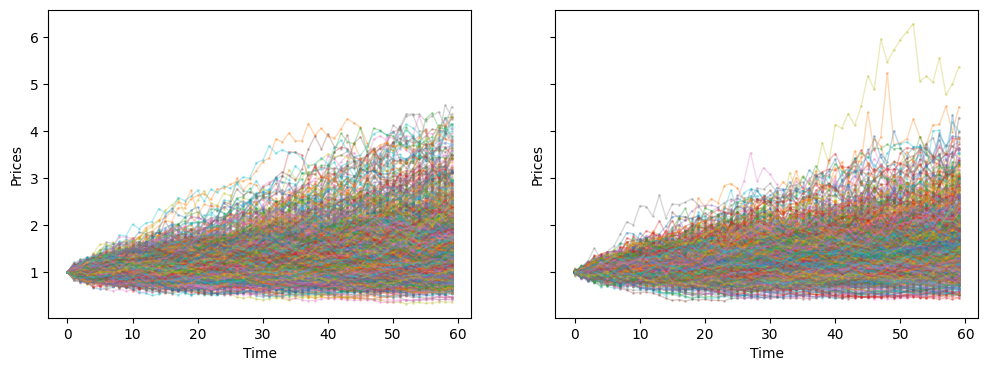

In [7]:
from evaluations.compare import compare_path
compare_path(real_data,fake_data)